In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Process grayscale image using PyTorch
def process_grayscale_image(image_path, target_size=(60, 60)):
    image = Image.open(image_path).convert("L")
    image_resized = image.resize(target_size)
    image_matrix = np.array(image_resized, dtype=np.float32) / 255.0  # Normalize to [0, 1]
    image_tensor = torch.tensor(image_matrix).flatten().to(device)  # Flatten and move to device
    return image_tensor

# Define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load images
image_path_cat = 'triangle.png'
image_path_dog = 'Square.png'
cat_tensor = process_grayscale_image(image_path_cat)
dog_tensor = process_grayscale_image(image_path_dog)

# Normalize vectors
cat_tensor = cat_tensor / torch.norm(cat_tensor) +0j
dog_tensor = dog_tensor / torch.norm(dog_tensor) +0j

# Generate structured grid
def gen_base(H, V, dx, dy, wavelength, f):
    x = torch.linspace(-(H / 2), (H / 2) - 1, H) * dx
    y = torch.linspace(-(V / 2), (V / 2) - 1, V) * dy
    fx = x / (wavelength * f)
    fy = y / (wavelength * f)
    X, Y = torch.meshgrid(x, y, indexing="ij")
    FX, FY = torch.meshgrid(fx, fy, indexing="ij")
    r = torch.sqrt(X**2 + Y**2)
    phi = torch.atan2(Y, X)
    return {
        "x": x.to(device),
        "y": y.to(device),
        "X": X.to(device),
        "Y": Y.to(device),
        "FX": FX.to(device),
        "FY": FY.to(device),
        "phi": phi.to(device),
        "r": r.to(device),
    }


In [45]:
# Initialize parameters
Mesh = gen_base(60, 60, 8e-6, 8e-6, 633e-9, 15e-3)
ffx = torch.exp(-2j * np.pi * Mesh['FX'].T*Mesh['X'])
ffy = torch.exp(-2j * np.pi * Mesh['FY'].T*Mesh['Y'])
F = torch.kron(ffx, ffy)
print("Shape of F = ",F.shape)
# F = torch.exp(-2j * np.pi * Mesh['FX']) @ torch.exp(-2j * np.pi * Mesh['FY'])

# Define phase matrix
def D(theta):
    return torch.diag(torch.exp(1j * theta))

# Define optical layers
def Optical_layers(phases, vec, num_layers=2):
    layer_size = len(phases) // num_layers
    output = vec
    for i in range(num_layers):
        start = i * layer_size
        end = (i + 1) * layer_size
        output = D(phases[start:end]) @ (F @ output)
    return output

# Define cost function
layers = 2
def cost_function(phases):
    output = Optical_layers(phases, cat_tensor,layers)
    mse = torch.mean(torch.abs(output - dog_tensor) ** 2)/60
    return mse


Shape of F =  torch.Size([3600, 3600])


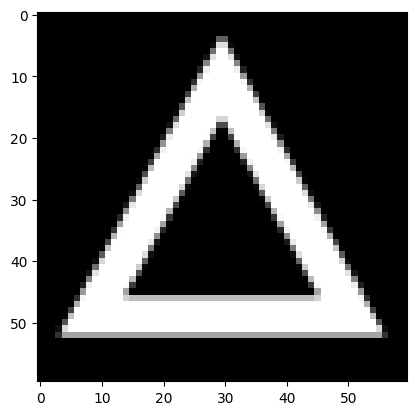

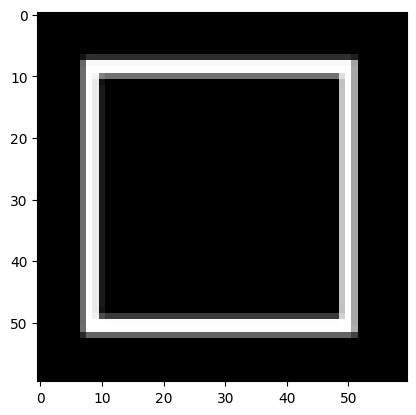

Norm of cat =  tensor(1.0000)


In [46]:
#Checking if the fourier matrix is normalized and unitary

out = cat_tensor.reshape(60,60)
dog_out = dog_tensor.reshape(60,60)
plt.imshow(torch.abs(out).cpu().detach().numpy(),cmap='gray')
plt.show()
plt.imshow(torch.abs(dog_out).cpu().detach().numpy() , cmap='gray')   
plt.show()
print("Norm of cat = ",torch.norm(cat_tensor))

Epoch 0, Cost: 2006.2864990234375
Epoch 100, Cost: 223.7981719970703
Epoch 200, Cost: 28.98591423034668
Epoch 300, Cost: 12.018929481506348
Epoch 400, Cost: 5.270339012145996
Epoch 500, Cost: 2.370081901550293
Epoch 600, Cost: 1.175700068473816
Epoch 700, Cost: 0.6929305791854858
Epoch 800, Cost: 0.4733215570449829
Epoch 900, Cost: 0.3535136878490448
Epoch 1000, Cost: 0.2777293622493744
Epoch 1100, Cost: 0.2251219004392624
Epoch 1200, Cost: 0.18615078926086426
Epoch 1300, Cost: 0.15573589503765106
Epoch 1400, Cost: 0.13134214282035828


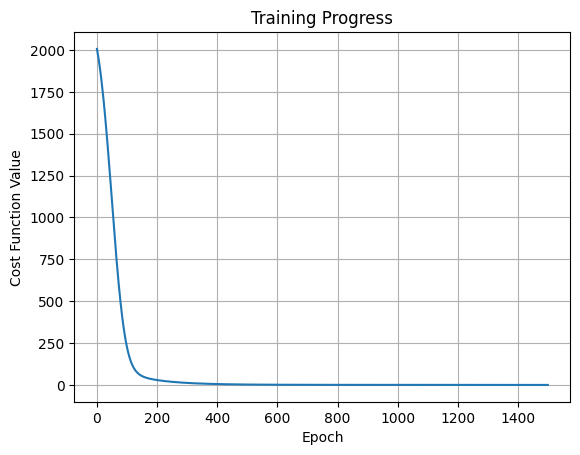

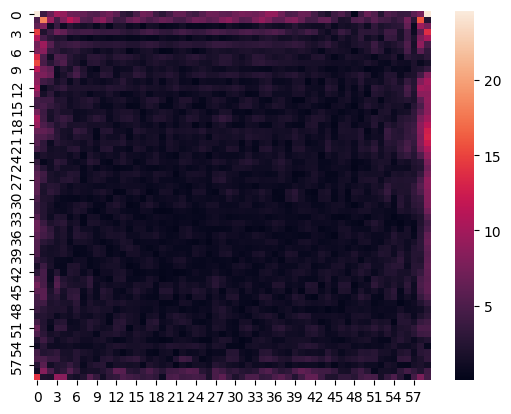

In [47]:
# Initialize phases
phases = torch.rand(3600*layers, device=device, requires_grad=True)

# Use Adam optimizer
optimizer = optim.Adam([phases], lr=0.01)

# Training loop
epochs = 1500
cost_history = []
for epoch in range(epochs):
    optimizer.zero_grad()
    cost = cost_function(phases)
    cost.backward()
    optimizer.step()
    cost_history.append(cost.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Cost: {cost.item()}")

# Plot cost history
plt.plot(cost_history)
plt.xlabel("Epoch")
plt.ylabel("Cost Function Value")
plt.title("Training Progress")
plt.grid()
plt.show()

# Visualize output
final_output = Optical_layers(phases, cat_tensor,layers).reshape(60, 60)
sns.heatmap(torch.abs(final_output).cpu().detach().numpy())
plt.show()

In [48]:
mse = torch.mean(torch.abs(final_output - dog_tensor) ** 2)/60

RuntimeError: The size of tensor a (60) must match the size of tensor b (3600) at non-singleton dimension 1